In [2]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np
import sys

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn import metrics

from sklearn.model_selection import ShuffleSplit

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
import multiprocessing

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import enchant
pd.set_option('display.max_rows', 500)

In [3]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

manualtag=pd.read_csv(Path+'SamplesManualTagger.csv')

varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

In [4]:
## if it is interdiscipilinary then -1 otherwise 0 (Normal data)
manualtag['interdiscipilinary']=-1
manualtag.loc[manualtag.apply(lambda x: (x['Category']==x['Category_1']) & (pd.isnull(x['Category_2'])) , axis=1),'interdiscipilinary']=0

## 1.1 Word Embedding

In [3]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list           
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [4]:
## creating a tagged document
DescDict=make_bigram([[x for x in str(i).split()] for i in df.PreProcessedDescription])

tagged_value = list(create_tagged_document(DescDict))

In [5]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=multiprocessing.cpu_count())

#### Hyper parameter ####
## vector_size  – Dimensionality of the feature vectors.
## If dm=1, ‘distributed memory’ (PV-DM) (CBOW - similar to continuous bag-of-words)
## alpha - The initial learning rate.
## min_count – Ignores all words with total frequency lower than this.

# Build the Volabulary
model.build_vocab(tagged_value)

model.train(tagged_value, total_examples=len(tagged_value), epochs=40)

print(str(datetime.datetime.now()),'Completed')

2020-02-19 16:20:37.197280 Started
2020-02-19 16:27:24.865597 Completed


In [6]:
## Validating the model response for random words 

modelchecked=model
target_word='laptop'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=20), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'laptop' model: Doc2Vec(dm/m,d50,n5,w5,mc5,s0.001,t4) similar words:
    1. 0.82 'notify'
    2. 0.82 'consumer electronic'
    3. 0.81 'mobile system'
    4. 0.80 'system smart'
    5. 0.79 'additional measure'
    6. 0.78 'integration platform'
    7. 0.78 'busy'
    8. 0.78 'meet high'
    9. 0.78 'maintenance free'
    10. 0.77 'goniometer'
    11. 0.77 'communication infrastructure'
    12. 0.76 'base station'
    13. 0.76 'video conferencing'
    14. 0.76 'tabletop'
    15. 0.75 'system fast'
    16. 0.75 'high investment'
    17. 0.75 'flexible production'
    18. 0.75 'challenge design'
    19. 0.74 'power engineering'
    20. 0.74 'mirror surface'


## 1.2. PCA

In [7]:
## PCA - reducing the dimenstion
ps=20
pcamodel = PCA(n_components=ps)
pca=pcamodel.fit_transform(model.docvecs.vectors_docs)
print('PCA components :',ps,'Variance coveragence' ,np.max(pcamodel.explained_variance_ratio_.cumsum())*100)

PCA components : 20 Variance coveragence 77.07423567771912


In [8]:
dummies=pd.get_dummies(df['Category'])
merged_data=pd.concat([df,dummies], axis=1,ignore_index=False)

merged_data=pd.concat([merged_data,pd.DataFrame(pca)], axis=1,ignore_index=False)

SubjectAreaIds=pd.DataFrame(enumerate(merged_data.SubjectArea.unique()),columns=['SubjectAreaId','SubjectArea2'])
finalcols=merged_data.columns.tolist()+['SubjectAreaId']
merged_data=merged_data.merge(SubjectAreaIds, how='left',left_on='SubjectArea',right_on='SubjectArea2')[finalcols]


merged_data=merged_data[pd.isnull(merged_data["Category"])==False]
merged_data['ISOForestCluster']=1

# 2. ISO Forest 

In [85]:
cat='Life Sciences'
FeatureCols=list(range(ps))

CategoricalDS=merged_data[FeatureCols][merged_data.Category==cat]

In [59]:
#CategoricalDS.head()

In [96]:
#tuned = {'n_estimators': list(range(1, 10, 5)), 'max_samples': list(range(1, 10, 5)), 'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_features': [5,10,15], 'n_jobs': [-1]}
#
tuned = {'contamination': ['auto'],'n_estimators': list(range(1, 100, 5)),'max_features': [10,15,20], 'max_samples': ['auto']}

def cv_silhouette_scorer(estimator, X):
    preds = estimator.fit_predict(X)
    score=silhouette_score(X, preds, metric='euclidean')
    if len(list(filter(lambda x:x==-1, preds)))<=550:
        return -1
    else:
        return score

def scorer_f(estimator, X):   #your own scorer
      return np.mean(estimator.score_samples(X))
    
isolation_forest = GridSearchCV(IsolationForest(behaviour="new"), tuned, scoring=cv_silhouette_scorer, cv=ShuffleSplit(test_size=.99, n_splits=1, random_state=0))
model = isolation_forest.fit(CategoricalDS)    

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(model.cv_results_).sort_values(by='rank_test_score').head(5)

In [ ]:
isolation_forest.best_estimator_

In [ ]:
clusterer = IsolationForest(behaviour='new', bootstrap=False, contamination=.01,
                max_features=20, max_samples=0.5, n_estimators=86, n_jobs=None,
                random_state=None, verbose=0, warm_start=False)
preds = clusterer.fit_predict(CategoricalDS)

#merged_data.loc[merged_data.Category==cat,'DBScanCluster']=preds
print('******'+cat+'******')
print(pd.Series(preds).value_counts())
score = silhouette_score(CategoricalDS, preds, metric='euclidean')
print('silhouette score:',score)
print(str(datetime.datetime.now()),'Completed')
print('')

In [ ]:
# n_estimators (default=100)    - The number of base estimators in the ensemble.
# max_samples  (default=”auto”) - The number of samples to draw from X to train each base estimator. If max_samples is larger than the number of samples provided, all samples will be used for all trees (no sampling)
# max_features (default=1.0)    - The number of features to draw from X to train each base estimator.
# contamination(default=’auto’) - The proportion of outliers in the data set. If float, the contamination should be in the range [0, 0.5].
# bootstrap (default=False)     - If True, individual trees are fit on random subsets of the training data sampled with replacement. If False, sampling without replacement is performed.

In [155]:
### DBSCAN - Density-Based Spatial Clustering of Applications with Noise. 
# Finds core samples of high density and expands clusters from them. 

FeatureCols=list(range(ps))

for cat in merged_data.Category.unique():
    print(str(datetime.datetime.now()),'Started')
    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    clusterer  =IsolationForest(behaviour='new', bootstrap=False, contamination=.07,
                max_features=20, max_samples=0.5, n_estimators=86, n_jobs=None,
                random_state=None, verbose=0, warm_start=False)
    #### Hyper parameter ####
    # 
    # 
    
    preds = clusterer.fit_predict(CategoricalDS)
    
    merged_data.loc[merged_data.Category==cat,'ISOForestCluster']=preds
    print('******'+cat+'******')
    print(pd.Series(preds).value_counts())
    score = silhouette_score(CategoricalDS, preds, metric='euclidean')
    print('silhouette score:',score)
    print(str(datetime.datetime.now()),'Completed')
    print('')
    

2020-02-19 20:51:12.114713 Started
******Natural Sciences******
 1    12763
-1      961
dtype: int64
silhouette score: 0.25866949563415587
2020-02-19 20:51:18.334937 Completed

2020-02-19 20:51:18.335011 Started
******Humanities and Social Sciences******
 1    9285
-1     699
dtype: int64
silhouette score: 0.25181583389309276
2020-02-19 20:51:21.850508 Completed

2020-02-19 20:51:21.851147 Started
******Engineering Sciences******
 1    8719
-1     657
dtype: int64
silhouette score: 0.24189628801473184
2020-02-19 20:51:24.889493 Completed

2020-02-19 20:51:24.889563 Started
******Life Sciences******
 1    16692
-1     1257
dtype: int64
silhouette score: 0.26127024419409633
2020-02-19 20:51:32.325550 Completed



In [156]:
merged_data['ISOForestCluster'].value_counts()

 1    47459
-1     3574
Name: ISOForestCluster, dtype: int64

In [157]:
## Reseting the index, converting category to int for supervised learning

def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1

merged_data=merged_data.reset_index()[merged_data.columns[0:]]

merged_data['CategoryConv']=merged_data.Category.apply(CattoID)

merged_data['CategoryConv']=merged_data['CategoryConv'].astype('int')

# 3. Supervised learning

In [158]:
Features=merged_data.columns[16:len(merged_data.columns)-2] #list(range(500))

merged_data[Features]=MinMaxScaler().fit_transform(merged_data[Features])

OP_Feature='CategoryConv'

## Training & Test data are splitted based on the ISOForestCluster result. outlier data are considering as test data to reevaluate.

X_Training_DS=merged_data[Features][merged_data.ISOForestCluster==1]
y_Training_DS=merged_data[OP_Feature][merged_data.ISOForestCluster==1]

X_Test_DS=merged_data[Features][merged_data.ISOForestCluster!=1]
y_Test_DS=merged_data[OP_Feature][merged_data.ISOForestCluster!=1]

X_train, X_test, y_train, y_test = train_test_split(X_Training_DS,y_Training_DS,  test_size=0.2, random_state=0)

## 3.1 NaiveBayes

Accuracy Score : 35.95659502739149


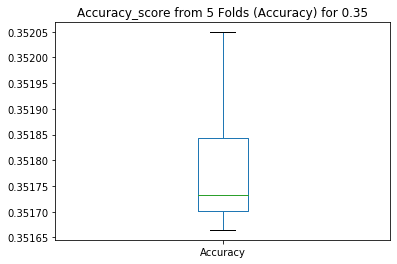

In [159]:
modelNB = MultinomialNB(alpha=1)

#### Hyper parameter ####
# alpha - Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

modelNB.fit(X_train, y_train)

nfolds=5
scores=cross_val_score(modelNB, X_Training_DS,y_Training_DS, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelNB.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))

## 3.1  k-nearest neighbors 

In [160]:
for k in [4,8,16,25,30]:
    modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    #### Hyper parameter ####
    # n_neighbors - Number of neighbors to use by default for kneighbors queries
    # weights - weight function used in prediction (‘distance’ : weight points by the inverse of their distance. 
    #in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.)
   
    modelKBC.fit(X_train, y_train)

    y_pred = modelKBC.predict(X_test)
    print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

    #nfolds=3
    #scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
    #pd.Series(scores).plot(kind="box", label="Accuracy");
    #plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

neighbors: 4 Accuracy Score : 0.8768436578171092
neighbors: 8 Accuracy Score : 0.8889591234723978
neighbors: 16 Accuracy Score : 0.8924357353560893
neighbors: 25 Accuracy Score : 0.8922250316055625
neighbors: 30 Accuracy Score : 0.8921196797302992


neighbors: 30 Accuracy Score : 0.8921196797302992


Text(0.5, 1.0, 'Accuracy_score from 3 Folds (Accuracy) for 0.89')

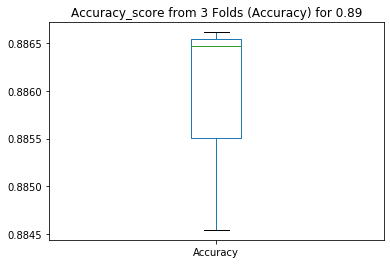

In [161]:
k=30
modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
modelKBC.fit(X_train, y_train)

y_pred = modelKBC.predict(X_test)
print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

nfolds=3
scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

In [162]:
# Print the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=3))

[[1398   61  235   55]
 [  30 1699   18   53]
 [  65   70 2273  123]
 [  68  111  135 3098]]
              precision    recall  f1-score   support

           0      0.896     0.799     0.845      1749
           1      0.875     0.944     0.908      1800
           2      0.854     0.898     0.876      2531
           3      0.931     0.908     0.919      3412

    accuracy                          0.892      9492
   macro avg      0.889     0.887     0.887      9492
weighted avg      0.893     0.892     0.892      9492



In [163]:
for x in [.01]+list(np.linspace(0.1,1,5))+[10]:

    modelSVC = svm.LinearSVC(C=x).fit(X_train, y_train)
    #### Hyper parameter ####
    # C - The strength of the regularization is inversely proportional to C.

    y_pred = modelSVC.predict(X_test)
    print('C -',x,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))


C - 0.01 Accuracy Score : 84.99789296249473
C - 0.1 Accuracy Score : 85.91445427728614
C - 0.325 Accuracy Score : 86.0408765276022
C - 0.55 Accuracy Score : 86.09355246523388
C - 0.775 Accuracy Score : 86.10408765276021
C - 1.0 Accuracy Score : 86.1251580278129
C - 10 Accuracy Score : 86.10408765276021


/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## 4. Formatting the output categories based on the predict_proba

In [164]:
## Based on predict_proba result. reorder to values and categories based on high probablity.

def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_1']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_1']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_1']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_1']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_2']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_2']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_2']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_2']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelKBC.predict_proba(merged_data[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

In [165]:
PredictedValues.loc[PredictedValues['Category_3_Values']<=.15,'Category_3']=''
PredictedValues.loc[PredictedValues['Category_2_Values']<=.15,'Category_2']=''

PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_2']=''
PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_3']=''



## 5.1. Random manual result evaluvation 

In [166]:
## regenerating dataset

NewMergedDSAligned=pd.concat([merged_data[merged_data.columns.tolist()[:12]+['ISOForestCluster']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

In [167]:
fil_1_2=(NewMergedDSAligned['Category_12_Variance']<=.10) & ((NewMergedDSAligned['Category_1']==NewMergedDSAligned['Category']) | (NewMergedDSAligned['Category_2']==NewMergedDSAligned['Category']))
fil_2_3=(NewMergedDSAligned['Category_23_Variance']<=.10) & ((NewMergedDSAligned['Category_3']==NewMergedDSAligned['Category']) | (NewMergedDSAligned['Category_2']==NewMergedDSAligned['Category']))

NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_1']=NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category']
NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_2']=''
NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_3']=''

In [168]:
#(NewMergedDSAligned.ISOForestCluster!=0) &

NewMergedDSAligned['ISOForestCluster'][ (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

 1    638
-1    427
Name: ISOForestCluster, dtype: int64

In [169]:
NewMergedDSAligned['ISOForestCluster'].value_counts()

 1    47459
-1     3574
Name: ISOForestCluster, dtype: int64

In [170]:
NewMergedDSAligned['Category'][(NewMergedDSAligned.ISOForestCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

Natural Sciences                  152
Life Sciences                     130
Engineering Sciences              101
Humanities and Social Sciences     44
Name: Category, dtype: int64

In [122]:
cats='Natural Sciences'
lim=20
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.ISOForestCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

,Translates,Category,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
45283,Global warming poses new threats to marine eco...,Natural Sciences,0.831660,0.168340,0.00000,Life Sciences,,,0.663319,0.168340
49483,The levels of numerous zinc transporter protei...,Natural Sciences,0.801560,0.198440,0.00000,Life Sciences,,,0.603120,0.198440
37108,Celiac disease (CD) is one of the most frequen...,Natural Sciences,0.800995,0.199005,0.00000,Life Sciences,,,0.601990,0.199005
48226,RNA interference (RNAi) caused by small interf...,Natural Sciences,0.798284,0.169256,0.03246,Life Sciences,Natural Sciences,,0.629028,0.136795
22309,The rapid expansion of nanotechnology has resu...,Natural Sciences,0.798270,0.201730,0.00000,Life Sciences,Natural Sciences,,0.596541,0.201730


In [123]:
#cats='Humanities and Social Sciences'
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.ISOForestCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()#.tail().

['Global warming poses new threats to marine ecosystems since rising seawater temperature potentially induces cascading effects in biogeochemical cycles and food webs. The Scientific Committee on Antarctic Research (SCAR) identified a better understanding of potential effects of climate change on the physical and biological uptake of CO2 by the Southern Ocean as one of the most pressing tasks in Antarctic research. Heterotrophic bacteria are the main producers of CO2 in the ocean, thereby counteracting the biological drawdown of CO2 by primary production. In Antarctic marine systems, low seawater temperature, and the low availability of labile organic matter are major environmental constraints on bacterial growth and degradation activity. However, temperature and the availability of resources for heterotrophic bacteria undergo considerable change induced by climate warming combined with subsequent ice melt and changes in primary productivity. Previous laboratory experiments conducted w

In [816]:
NewMergedDSAligned.to_csv(Path+'WEPCAISOFindingsKMeans.csv', index=False)

## 5.2. Each category TF/IDF based result evaluvation 

In [171]:
#&(NewMergedDSAligned['Category']==cats) &(NewMergedDSAligned['Category_1']==check_cat)

input_data=NewMergedDSAligned[(NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1']) & (NewMergedDSAligned.ISOForestCluster!=1) ]

input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1','Category_2','Category_3']].apply(lambda x:x[0]+','+x[1]+','+x[2]+','+x[3], axis=1)
#input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1']].apply(lambda x:x[0]+','+x[1], axis=1)
input_data.loc[:,'CategoryCollc']=input_data['CategoryCollc'].str.strip(",")

/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [172]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
varclusterall=varclusterall[varclusterall.RS_Ratio<.98]

In [173]:
def find_category(target_word):
    try :
        sim_word=list(map(lambda x:x[0] ,modelchecked.wv.most_similar(target_word, topn=5)))
        finalcategory=varclusterall[varclusterall.Variable.isin(sim_word)].category.value_counts().sort_values(ascending=False).head(1).index
        if(len(finalcategory)>0):
            return finalcategory[0]
        else:
            return np.NaN
    except :
        return np.NaN

In [174]:
sizes=len(input_data.CategoryCollc.unique())
category_tfidfs=pd.DataFrame()

with tqdm(total=len(input_data['CategoryCollc'].unique())) as bar:
    for i,bucket in input_data.groupby(['CategoryCollc']):
        varcat=pd.DataFrame()

        vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1, 1))
        review_vectors = vectorizer.fit_transform(bucket["PreProcessedDescription"])
        features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

        varcat=pd.DataFrame(features_df.sum().sort_values(ascending=False)).merge(varclusterall, how='left', left_index=True, right_on='Variable')[[0,'Variable','category']]
        varcat.category=varcat[['Variable', 'category']].apply(lambda x: find_category(x.Variable) if(pd.isnull(x['category'])) else x['category'], axis=1)

        varcat['bucket_length']=len(bucket)
        varcat['bucket_category']=bucket['Category'].unique()[0]
        varcat['Category_1']=bucket['Category_1'].unique()[0]
        varcat['Category_2']=bucket['Category_2'].unique()[0]
        varcat['Category_3']=bucket['Category_3'].unique()[0]

        varcat['Category_1_Score']=bucket['Category_1_Values'].mean()
        varcat['Category_2_Score']=bucket['Category_2_Values'].mean()
        varcat['Category_3_Score']=bucket['Category_3_Values'].mean()

        varcat=varcat.reset_index()

        category_tfidfs=pd.concat([varcat[varcat.columns[1:]],category_tfidfs])
        bar.update(1)

100%|██████████| 64/64 [00:21<00:00,  3.29it/s]


In [141]:
category_tfidfs.to_csv(Path+'CategoryTFIDFSummary_WEPCAISOForestFindingsKMeansV2_Exp1.2.0.csv', index=False)

# Visualization

In [175]:
def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1


NewMergedDSAligned2=pd.concat([merged_data,PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

NewMergedDSAligned2.loc[:,'Category_1_ID']=NewMergedDSAligned2.Category_1.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_2_ID']=NewMergedDSAligned2.Category_2.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_3_ID']=NewMergedDSAligned2.Category_3.apply(CattoID)

NewMergedDSAligned2=pd.DataFrame(enumerate(NewMergedDSAligned2.SubjectArea.unique()), columns=['Subjectid','SubjectAreaMatching']).merge(NewMergedDSAligned2,left_on='SubjectAreaMatching', right_on='SubjectArea')

cats=['Engineering Sciences','Humanities and Social Sciences', 'Life Sciences','Natural Sciences']
cats_dist=[]

## Finiding the overall similiarity

for c, w in NewMergedDSAligned2[(NewMergedDSAligned2['Category']!=NewMergedDSAligned2['Category_1']) & (NewMergedDSAligned2['ISOForestCluster']!=1)].groupby('Category'):
    #print('')
    #print(c, len(w))
    #other_cat=list(filter(lambda x:x!=c, cats))
    cat_dist=[]
    for oc in cats:
        if oc==c:
            oc_sim=0
            
        else:
            oc_sum=sum(w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist())
            oc_sim=oc_sum/len(w)
            
        cat_dist.append(oc_sim)
        #print(c,':',oc,'-', round(oc_sim,2))
        
        #oc_sum=w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist()
        #oc_sim=sum(oc_sum)/len(oc_sum)
        #print(c,':',oc,'-', round(oc_sim,2))
    cats_dist.append(np.array(cat_dist))
cats_dist=np.array(cats_dist)

## Making symmetric matrix
sym_dist=np.zeros(cats_dist.shape)
for i in range(cats_dist.shape[0]):
    for j in range(cats_dist.shape[0]):
        sym_dist[i][j]=cats_dist[i][j]+ cats_dist[j][i]
        if(i==j):
            sym_dist[i][j]=1

# 1-x : convert similiarity to distance
sym_dist=1-pd.DataFrame(sym_dist, columns=cats, index=cats)

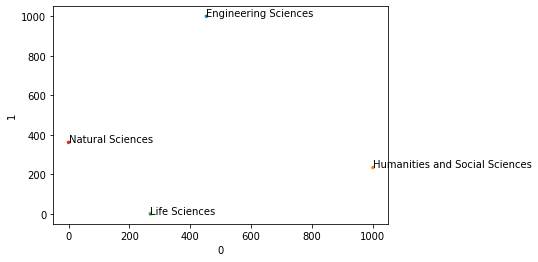

In [176]:
## Generating coordinates from distance

#, angle=0.8

#coords = TSNE(n_components=2,perplexity=.1, random_state=12, metric='precomputed').fit_transform(sym_dist)

#coords = TSNE(n_components=2,perplexity=4.2, random_state=18, metric='precomputed').fit_transform(sym_dist)
coords = PCA(n_components=2).fit_transform(sym_dist)

coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=cats).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="index",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
);

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], cats[line], horizontalalignment='left',  size='medium', color='black')

In [177]:
sym_dist

,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
Engineering Sciences,0.000000,0.600824,0.600372,0.464509
Humanities and Social Sciences,0.600824,0.000000,0.489380,0.814216
Life Sciences,0.600372,0.489380,0.000000,0.240301
Natural Sciences,0.464509,0.814216,0.240301,0.000000


In [178]:
newrange=pd.DataFrame(NewMergedDSAligned2.Category.value_counts()/80).reset_index().merge(coords,left_on='index',right_on='index')
newrange.loc[:,'Min_X']=newrange[0]-newrange['Category']
newrange.loc[:,'Max_X']=newrange[0]+newrange['Category']
newrange.loc[:,'Min_Y']=newrange[1]-(newrange['Category']*.60)
newrange.loc[:,'Max_Y']=newrange[1]+(newrange['Category']*.60)

newrange.columns=['Category','size', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']
newrange

,Category,size,0,1,Min_X,Max_X,Min_Y,Max_Y
0,Life Sciences,224.3625,268.676091,0.000000,44.313591,493.038591,-134.617500,134.617500
1,Natural Sciences,171.5500,0.000000,362.183597,-171.550000,171.550000,259.253597,465.113597
2,Humanities and Social Sciences,124.8000,1000.000000,234.292842,875.200000,1124.800000,159.412842,309.172842
3,Engineering Sciences,117.2000,452.768651,1000.000000,335.568651,569.968651,929.680000,1070.320000


In [180]:
catsperplexity={'Engineering Sciences':5,'Humanities and Social Sciences':5, 'Life Sciences':10,'Natural Sciences':8}

## T-SNE separately for each categories

outerclusterfeatures=['Category_1_Values','Category_1_ID','Category_2_ID','Category_2_Values','Category_3_ID','Category_3_Values','Subjectid']
#Doc2VecModelData=pd.concat([pd.DataFrame(model.docvecs.vectors_docs),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
Doc2VecModelData=pd.concat([pd.DataFrame(pca[:,:10]),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
    
Doc2VecModelData['tsne-2d-one']=0
Doc2VecModelData['tsne-2d-two']=0

for cat in cats:#['Life Sciences']:#
    print(str(datetime.datetime.now()),'Started for', cat)
    
    tsne = TSNE(n_components=2, perplexity=catsperplexity[cat], n_iter=300, random_state=0, learning_rate=100)
    ## The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. 
    ## Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. 
    
    tsne_results = tsne.fit_transform(Doc2VecModelData[NewMergedDSAligned2.Category==cat])
    
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-one'] = tsne_results[:,0]
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-two'] = tsne_results[:,1]

    print(str(datetime.datetime.now()),'Completed for', cat)
    

Doc2VecModelData.loc[:,'Category'] = NewMergedDSAligned2.Category
Doc2VecModelData.loc[:,'Category_1'] = NewMergedDSAligned2.Category_1


2020-02-19 21:12:53.775155 Started for Engineering Sciences
2020-02-19 21:13:16.697972 Completed for Engineering Sciences
2020-02-19 21:13:16.698196 Started for Humanities and Social Sciences
2020-02-19 21:13:40.058818 Completed for Humanities and Social Sciences
2020-02-19 21:13:40.059062 Started for Life Sciences
2020-02-19 21:14:23.165591 Completed for Life Sciences
2020-02-19 21:14:23.166045 Started for Natural Sciences
2020-02-19 21:14:57.799016 Completed for Natural Sciences


In [149]:
# Reshaping
for cat in cats:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-one']=model_x.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-one']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-two']=model_y.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-two']])


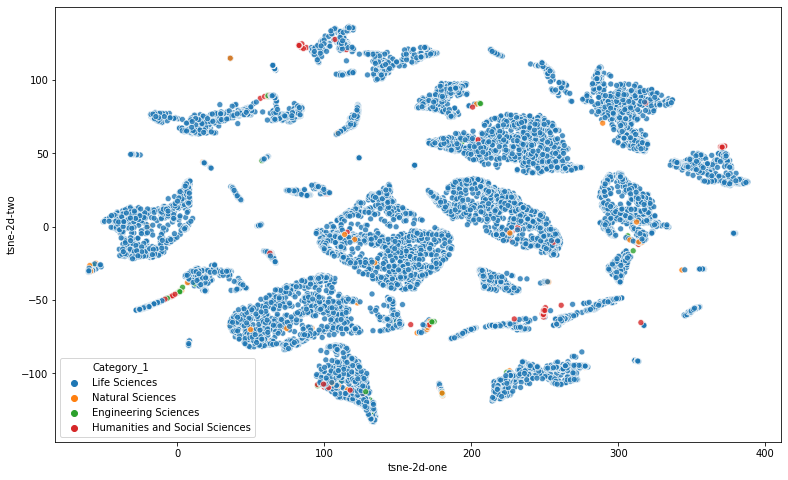

In [150]:
cat='Life Sciences'#'Engineering Sciences'#'Life Sciences'#'Humanities and Social Sciences'#'Life Sciences'#'
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData[Doc2VecModelData.Category==cat],
        legend="full",
#        style='Category_1',
        alpha=0.8
    );

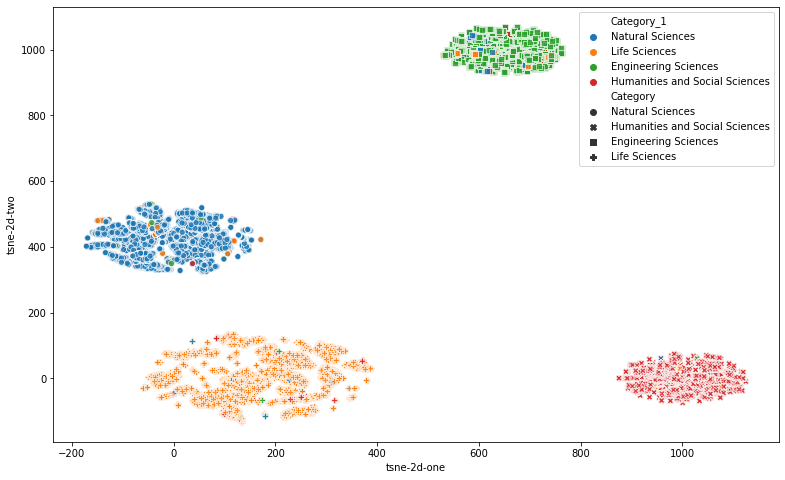

In [151]:
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData,
        legend="full",
        style='Category',
        alpha=0.8
    );

In [181]:
def label_genarator(input):
    if((input.Category==input.Category_1) or (input.ISOForestCluster==1)):
        return ''#'Category : '+input.Category
    else:
        if((input.Category_3_Values==0) and (input.Category_2_Values==0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%'+')'
        elif((input.Category_3_Values==0) and (input.Category_2_Values!=0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%)'
        else:
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%, '+input.Category_3+' '+str(round(input.Category_3_Values*100))+'%)'
        
        
Report_extrat=pd.concat([NewMergedDSAligned2[['Name','Institution','FundingFrom','FundingEnd', 'Category','Category_1_Values','Category_2_Values','Category_3_Values','Category_1','Category_2','Category_3','ISOForestCluster']],Doc2VecModelData[['tsne-2d-one', 'tsne-2d-two']]], axis=1)
Report_extrat['ProjectURL']=NewMergedDSAligned2.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)
Report_extrat['label']=Report_extrat.apply(label_genarator, axis=1)
Report_extrat['interdiscipilinary']=False
Report_extrat.loc[(Report_extrat.label!='') & (Report_extrat['ISOForestCluster']!=1),'interdiscipilinary']=True

In [182]:
Report_extrat['color']=Report_extrat['Category']
Report_extrat.loc[Report_extrat['interdiscipilinary'],'color']=Report_extrat.loc[Report_extrat['interdiscipilinary'],'Category_1']

In [183]:
Report_extrat.to_csv(Path+'Report_WEPCAISOForestFindingsKMeans.csv', index=False)
newrange.to_csv(Path+'CATRANGE_WEPCAISOForestFindingsKMeans.csv', index=False)